In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

from features import categorical_features, skewed_features, unskewed_features, cols_idxs
from scores import save_score

In [17]:
df = pd.read_csv(os.path.join("data", "processed", "all_data2.csv"))
df.set_index("commune_id", inplace=True)
df.drop(columns=["name"], inplace=True)
vote_share_cols = [col for col in df.columns if col.startswith("vote_share_")]
df.drop(columns=vote_share_cols, inplace=True)

In [18]:
df_typo = df["typology"] # needed for stratification below

df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df_typo)
X_train = df_train.drop(columns="po_value").values
y_train = df_train["po_value"].values
X_test = df_test.drop(columns="po_value").values
y_test = df_test["po_value"].values

print("X_train.shape = {}".format(X_train.shape))
print("y_train.shape = {}".format(y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("y_test.shape = {}".format(y_test.shape))

X_train.shape = (1756, 54)
y_train.shape = (1756,)
X_test.shape = (440, 54)
y_test.shape = (440,)


In [19]:
categorical_idxs = cols_idxs(df.drop(columns="po_value"), categorical_features)

preprocessor = make_column_transformer(
    (OneHotEncoder(dtype=np.float64), categorical_idxs),
    remainder = "passthrough"
)

gtbr = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=0))
gtbr.fit(X_train, y_train)
gtbr_test_pred = gtbr.predict(X_test)
print("With default params:")
print("GTBR MAE = {:.3f}".format(mean_absolute_error(y_test, gtbr_test_pred)))
print("GTBR R^2 = {:.3f}".format(gtbr.score(X_test, y_test)))

With default params:
GTBR MAE = 0.156
GTBR R^2 = 0.743


In [5]:
parameters = {
    "learning_rate": [0.08, 0.09, 0.1, 0.11, 0.12 ],
    "n_estimators": np.linspace(100, 800, 8, dtype=int)
}
gcv = GridSearchCV(gtbr, parameters, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv.best_params_))
print("Best MAE = {:.3f}".format(-gcv.best_score_))

Grid search / cross-validation:
Best params = {'learning_rate': 0.08, 'n_estimators': 800}
Best MAE = 0.153


In [6]:
gcv_test_pred = gcv.predict(X_test)
gcv_test_mae = mean_absolute_error(y_test, gcv_test_pred)
gcv_test_r2 = r2_score(y_test, gcv_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gcv_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gcv_test_r2))

On test data:
Tuned GTBR MAE = 0.151
Tuned GTBR R^2 = 0.758


In [7]:
df_gcv = pd.DataFrame(gcv.cv_results_)[['rank_test_score', 'mean_train_score', 'std_train_score', 'mean_test_score',
                                         'std_test_score', 'param_learning_rate', 'param_n_estimators']].sort_values(by='rank_test_score')
df_gcv.head()

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,param_learning_rate,param_n_estimators
7,1,-0.035742,0.000626,-0.153441,0.005783,0.08,800
6,2,-0.041691,0.000596,-0.153452,0.005531,0.08,700
12,3,-0.052103,0.001555,-0.153464,0.004782,0.09,500
5,4,-0.048757,0.000414,-0.153680,0.005403,0.08,600
20,5,-0.046801,0.000945,-0.153688,0.004545,0.1,500


In [8]:
parameters2 = {
    "learning_rate": [0.09],
    "n_estimators": [500],
    "max_depth": np.linspace(1, 10, 10, dtype=int),
    "min_samples_split": np.linspace(2, 10, 10, dtype=int)
}
gcv2= GridSearchCV(gtbr, parameters2, scoring = "neg_mean_absolute_error", cv = 5, n_jobs=12, return_train_score=True)
gcv2.fit(X_train, y_train)
print("Grid search / cross-validation:")
print("Best params = {}".format(gcv2.best_params_))
print("Best MAE = {:.3f}".format(-gcv2.best_score_))

Grid search / cross-validation:
Best params = {'learning_rate': 0.09, 'max_depth': 4, 'min_samples_split': 10, 'n_estimators': 500}
Best MAE = 0.152


In [9]:
gcv2_test_pred = gcv2.predict(X_test)
gcv2_test_mae = mean_absolute_error(y_test, gcv2_test_pred)
gcv2_test_r2 = r2_score(y_test, gcv2_test_pred)
print("On test data:")
print("Tuned GTBR MAE = {:.3f}".format(gcv2_test_mae))
print("Tuned GTBR R^2 = {:.3f}".format(gcv2_test_r2))
save_score("gtbr", gcv2_test_mae, gcv2_test_r2, os.path.join("data", "results", "model_scores.csv"))

On test data:
Tuned GTBR MAE = 0.150
Tuned GTBR R^2 = 0.764


In [10]:
df_gcv2 = pd.DataFrame(gcv2.cv_results_)[['rank_test_score', 'mean_train_score', 'std_train_score', 'mean_test_score',
                                         'std_test_score', 'param_learning_rate', 'param_n_estimators', 'param_max_depth',
                                         'param_min_samples_split']].sort_values(by='rank_test_score')
df_gcv2.head(5)

,rank_test_score,mean_train_score,std_train_score,mean_test_score,std_test_score,param_learning_rate,param_n_estimators,param_max_depth,param_min_samples_split
39,1,-0.022553,0.000230,-0.152225,0.004738,0.09,500,4,10
34,2,-0.021527,0.000503,-0.152428,0.004164,0.09,500,4,5
33,3,-0.021197,0.000632,-0.152980,0.004421,0.09,500,4,4
37,4,-0.021649,0.000449,-0.153285,0.005384,0.09,500,4,8
21,5,-0.052103,0.001555,-0.153464,0.004782,0.09,500,3,2


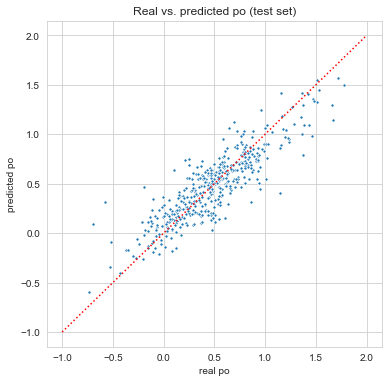

In [11]:
sns.set_style('whitegrid')
plt.figure(figsize=(6,6))
ax = sns.scatterplot(y_test, gcv2_test_pred, s=10)
ax.set_xlabel("real po")
ax.set_ylabel("predicted po")
ax.set_title("Real vs. predicted po (test set)")
ax.plot([-1, 2], [-1, 2], color="red", linestyle=":")
plt.show()

In [12]:
sns.set_style('whitegrid')
def validationcurve_plot(title, param_range, train_scores_mean, train_scores_std, valid_scores_mean, valid_scores_std, ax):
    """Plots a validation curve and marks the best test score."""

    sns.lineplot(param_range, train_scores_mean, label="train", ax=ax)
    ax.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)

    sns.lineplot(param_range, valid_scores_mean, label="validation", ax=ax)
    ax.fill_between(param_range, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.2)

    ax.set_title(title)
    ax.set_xlabel("n_estimators")

    best_idx = valid_scores_mean.values.argmin()
    ax.scatter(param_range[best_idx], valid_scores_mean[best_idx], marker='x', c='red', zorder=10, label="best")

    ax.legend()

In [13]:
# this is just for the charts
param_range = np.append(np.linspace(10, 90, 9, dtype=int), np.linspace(100, 800, 8, dtype=int))
parameters3 = { "learning_rate": [0.09], "n_estimators": param_range, "max_depth": [4], "min_samples_split": [10] }
gcv3 = GridSearchCV(GradientBoostingRegressor(random_state=0), parameters3, scoring = "neg_mean_absolute_error",
                   cv = 5, n_jobs=12, return_train_score=True)
gcv3.fit(X_train, y_train)
df_gcv3 = pd.DataFrame(gcv3.cv_results_)

parameters4 = { "learning_rate": [0.12], "n_estimators": param_range, "max_depth": [4], "min_samples_split": [10] }
gcv4 = GridSearchCV(GradientBoostingRegressor(random_state=0), parameters4, scoring = "neg_mean_absolute_error",
                   cv = 5, n_jobs=12, return_train_score=True)
gcv4.fit(X_train, y_train)
df_gcv4 = pd.DataFrame(gcv4.cv_results_)

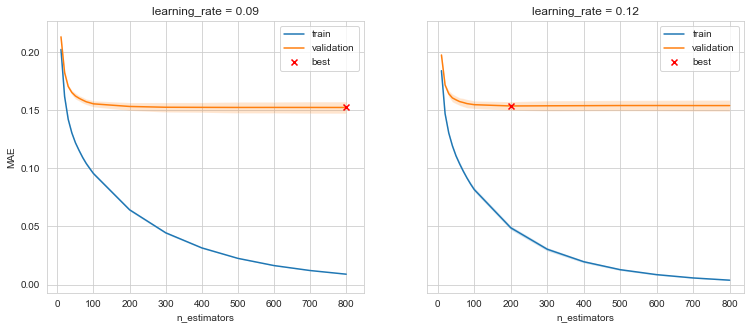

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 5), sharey=True)
validationcurve_plot("learning_rate = 0.09", param_range, -df_gcv3["mean_train_score"], -df_gcv3["std_train_score"],
                     -df_gcv3["mean_test_score"], -df_gcv3["std_test_score"], ax=ax1)
ax1.set_ylabel("MAE")
validationcurve_plot("learning_rate = 0.12", param_range, -df_gcv4["mean_train_score"], -df_gcv4["std_train_score"],
                     -df_gcv4["mean_test_score"], -df_gcv4["std_test_score"], ax=ax2)

In [15]:
print("learning rate = 0.09, MAE={:.3f}".format(-gcv3.score(X_test, y_test)))
print("learning rate = 0.12, MAE={:.3f}".format(-gcv4.score(X_test, y_test)))

learning rate = 0.09, MAE=0.152
learning rate = 0.12, MAE=0.151
